# Plot Gauge Partcle Distribution

2023.07.26 Kurama Okubo

We obtained the particle size distribution of the gouge from the datasheet and plotted it using cubic spline interpolation. Note that the interpolated values do not always represent the actual particle size measurements but are useful for evaluating the size distribution.

- 2025.03.18 update for the master plot.

- 2025.4.10 **NOTE** The percentile diameters are taken from the original datasheet rather than the interpolated curve shown in this notebook. The diffrences are ~0.1 μmm, so it does not affect the interpretation.

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.integrate import cumulative_trapezoid
import matplotlib.ticker as mticker

from tqdm import tqdm
import warnings

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

We use the `rock T-3 Run 200um pass` to synthesize the gauge patch. We first parse the data sheet.

In [2]:
figdir = "./figure"

if not os.path.exists(figdir):
    os.makedirs(figdir)

darr =  np.loadtxt('./T-3_Run_200um_pass_datasheet.txt')
data = darr.reshape(100, 3)
df_darr = pd.DataFrame(data, columns=["X", "Q3", "q3"]) 

<Axes: >

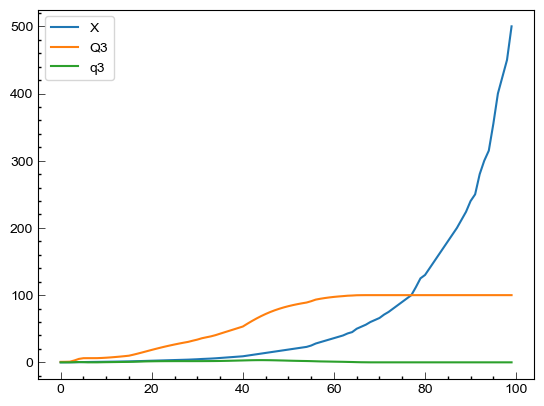

In [3]:
df_darr.plot()

In [4]:
df_darr

,X,Q3,q3
0,0.04,0.71,0.00
1,0.07,0.79,0.01
2,0.10,0.96,0.04
3,0.20,2.77,0.20
4,0.30,5.11,0.43
...,...,...,...
95,355.00,100.00,0.00
96,400.00,100.00,0.00
97,425.00,100.00,0.00
98,450.00,100.00,0.00


Plot the denity distribution with logarithmic scale of x.
Reference : https://stackoverflow.com/questions/69183241/how-to-create-a-bar-plot-with-a-logarithmic-x-axis-and-gaps-between-the-bars

Text(0, 0.5, 'Frequency')

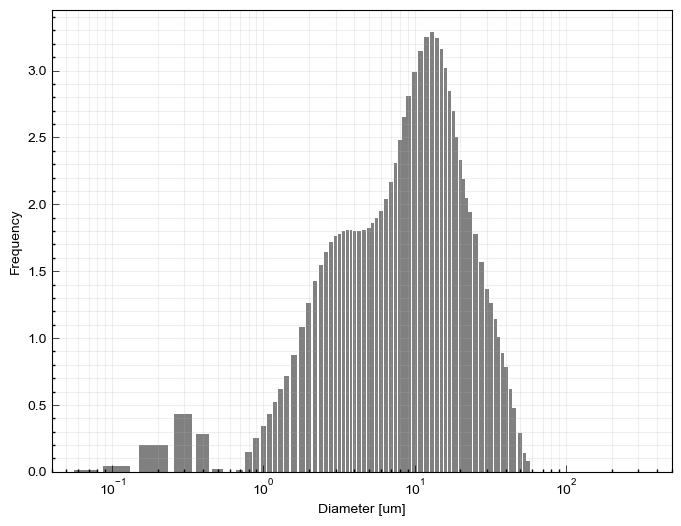

In [5]:
xlimit = [0.04, 500]


fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = list(df_darr["X"].values)
q3 = df_darr["q3"].values #NOTE: ds may not be a density but may be a mass probability such that the sum is 100%. 

padded_x = [x[0] / 10] + x + [x[-1] * 10]
width = 0.8  # 1 for full width, closer to 0 for thinner bars
lefts = [x1 ** (1 - width / 2) * x0 ** (width / 2) for x0, x1 in zip(padded_x[:-2], padded_x[1:-1])]
rights = [x0 ** (1 - width / 2) * x1 ** (width / 2) for x0, x1 in zip(padded_x[1:-1], padded_x[2:])]
widths = [r - l for l, r in zip(lefts, rights)]

ax.bar(lefts, q3, widths, align='edge', facecolor='gray', lw=0)
ax.set_xscale('log')

ax.grid(which='both', alpha=0.2, zorder=-2)
ax.set_xlim(xlimit)

ax.set_xlabel("Diameter [um]")
ax.set_ylabel("Frequency")

The data sheet in the pdf is sparse, which does not contain all the data although we can reproduce the diagram of particle size distribution. We thus fit the curve to plot the particle densities.

**NOTE:** The raw data shows the distribution normalized such that the sum is 100 [%]. Therefore, this could indicate the mass probability of the diameter.

In [6]:
np.sum(q3)

100.0

In [7]:
cs = CubicSpline(x, q3)
xs = np.logspace(np.log10(0.04), np.log10(500), 81)
qs = cs(xs)
# ds_scaled = ds/(np.trapz(ds, x=xs)*0.01) # rescale such that the summation of interpolated density is 100[%]
qs_scaled = qs/np.sum(qs) * 100 # rescale such that the summation of interpolated density is 100[%]

# check if the sum of ds is 100 %
# ds_integral = np.trapz(ds_scaled, x=xs) % NOTE: ds may not be a density but may be a mass probability

print(f"Sum of ds_scaled is {np.sum(qs_scaled):.1f} [%].")

Sum of ds_scaled is 100.0 [%].


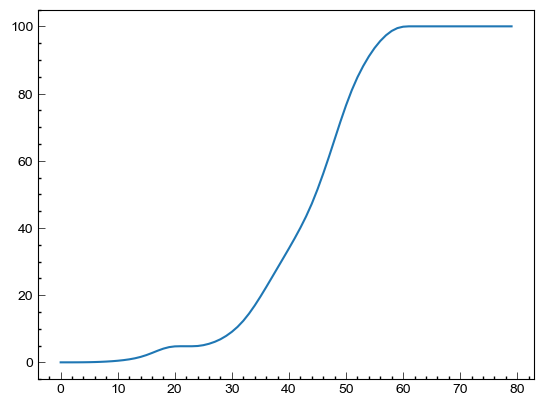

In [8]:
# search the median
qs_cumtrapz = cumulative_trapezoid(qs_scaled)

plt.plot(qs_cumtrapz)

In [9]:
d10 = xs[np.where(qs_cumtrapz >= 10)[0][0]]
d50 = xs[np.where(qs_cumtrapz >= 50)[0][0]]
d90 = xs[np.where(qs_cumtrapz >= 90)[0][0]]
print("The diameter is :", d10, d50, d90)

The diameter is : 1.547435733396764 8.06439652189943 23.30634924772857


The diameter documented in the data sheet is 

- D10 = 1.41, D50 = 8.23, and D90 = 23.98.

The subtle difference is caused due to the spline fitting. You can find the numbers are well reproduced from the data sheet.

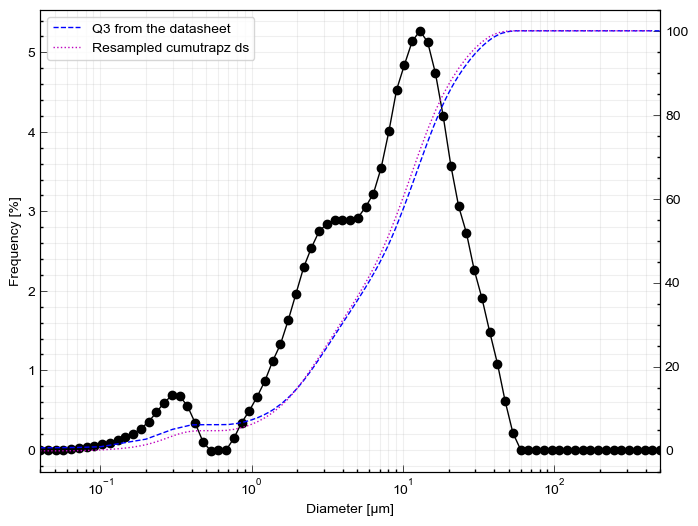

In [10]:
# Plot for debug
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = list(df_darr["X"].values)
q3 = df_darr["q3"].values

padded_x = [x[0] / 10] + x + [x[-1] * 10]
width = 0.8  # 1 for full width, closer to 0 for thinner bars
lefts = [x1 ** (1 - width / 2) * x0 ** (width / 2) for x0, x1 in zip(padded_x[:-2], padded_x[1:-1])]
rights = [x0 ** (1 - width / 2) * x1 ** (width / 2) for x0, x1 in zip(padded_x[1:-1], padded_x[2:])]
widths = [r - l for l, r in zip(lefts, rights)]

# Note: the below is rescaled for ds_scaled, so the amplitude is different to ds_scaled. Just for debug.
# ax.bar(lefts, q3, widths, align='edge', facecolor='gray', lw=0) 

ax.plot(xs, qs_scaled, "k-o", lw=1)

ax.set_xscale('log')

# plot cumulative volume
ax2 = ax.twinx()

ax2.plot(x, df_darr["Q3"], "b--", lw=1, label="Q3 from the datasheet")
ax2.plot(xs[:-1], qs_cumtrapz, "m:", lw=1, label="Resampled cumutrapz ds")
ax2.set_xscale('log')

ax.grid(which='both', alpha=0.2, zorder=-2)
# ax.set_ylim([0, 0.05])
ax.set_xlim(xlimit)
ax2.legend(loc=0)

ax.set_xlabel("Diameter [µm]")
ax.set_ylabel("Frequency [%]")

plt.savefig(figdir+"/gouge_diameter_debug.png", format="png", dpi=80)


Figure: we confirmed the interpolated cumulative diameter is reproduced from the data sheet.


In [11]:
[xs[0] / 10]

[0.004000000000000001]

In [12]:
np.hstack([xs[0] / 10, xs, xs[-1] * 10])

array([4.00000000e-03, 4.00000000e-02, 4.50060985e-02, 5.06387226e-02,
       5.69762834e-02, 6.41070056e-02, 7.21301553e-02, 8.11574219e-02,
       9.13144731e-02, 1.02742704e-01, 1.15601207e-01, 1.30068983e-01,
       1.46347436e-01, 1.64663178e-01, 1.85271180e-01, 2.08458325e-01,
       2.34547398e-01, 2.63901582e-01, 2.96929515e-01, 3.34090975e-01,
       3.75903284e-01, 4.22948505e-01, 4.75881552e-01, 5.35439301e-01,
       6.02450848e-01, 6.77849055e-01, 7.62683534e-01, 8.58135257e-01,
       9.65532998e-01, 1.08637183e+00, 1.22233394e+00, 1.37531204e+00,
       1.54743573e+00, 1.74110113e+00, 1.95900422e+00, 2.20417842e+00,
       2.48003678e+00, 2.79041949e+00, 3.13964737e+00, 3.53258197e+00,
       3.97469330e+00, 4.47213595e+00, 5.03183478e+00, 5.66158130e+00,
       6.37014214e+00, 7.16738112e+00, 8.06439652e+00, 9.07367561e+00,
       1.02092685e+01, 1.14869835e+01, 1.29246078e+01, 1.45421543e+01,
       1.63621408e+01, 1.84099030e+01, 2.07139477e+01, 2.33063492e+01,
      

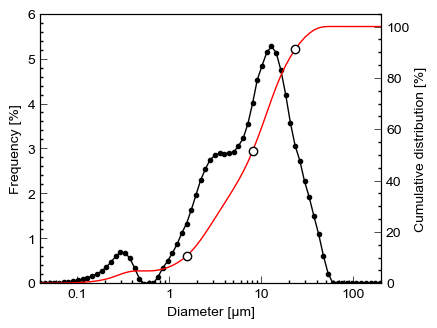

In [13]:
# Master plot
fig, ax = plt.subplots(1, 1, figsize=(4.4, 3.5))#figsize=(8, 5.5))

# bar plot with log scale
padded_xs = np.hstack([xs[0] / 10, xs, xs[-1] * 10])
width = 0.9  # 1 for full width, closer to 0 for thinner bars
lefts = [x1 ** (1 - width / 2) * x0 ** (width / 2) for x0, x1 in zip(padded_xs[:-2], padded_xs[1:-1])]
rights = [x0 ** (1 - width / 2) * x1 ** (width / 2) for x0, x1 in zip(padded_xs[1:-1], padded_xs[2:])]
widths = [r - l for l, r in zip(lefts, rights)]

# Note: the below is rescaled for ds_scaled, so the amplitude is different to ds_scaled. Just for debug.
# ax.bar(lefts, q3, widths, align='edge', facecolor='gray', lw=0) 

# ax.bar(xs, qs_scaled, widths, align='edge', facecolor=[0.7, 0.7, 0.7], lw=1) 
# ax.plot(xs, qs_scaled, "k-o", lw=1)

ax.plot(xs, qs_scaled, "k.-", lw=1)

ax.set_xscale('log')

# ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
# ax.set_axisbelow('True')

ax.set_ylim([0, 6])
ax.set_xlim([0.04, 200])
ax.set_xlabel("Diameter [µm]")
ax.set_ylabel("Frequency [%]")

# plot cumulative volume
ax2 = ax.twinx()

# ax2.plot(x, df_darr["Q3"], "b--", lw=1, label="Q3 from the datasheet")
ax2.plot(xs[:-1], qs_cumtrapz, "r-", lw=1) # We plot the cumulative diameter with recomputed one.
ax2.set_xscale('log')
ax2.set_ylabel('Cumulative distribution [%]')
ax2.set_ylim([0, 105])

# Plot D10, D50, D90 markers
q10 = qs_cumtrapz[np.where(qs_cumtrapz >= 10)[0][0]]
q50 = qs_cumtrapz[np.where(qs_cumtrapz >= 50)[0][0]]
q90 = qs_cumtrapz[np.where(qs_cumtrapz >= 90)[0][0]]

ax2.plot([d10, d50, d90], [q10, q50, q90], "o",  markerfacecolor="w", markeredgecolor="k")

ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.3g'))
# ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1g'))

plt.savefig(figdir+"/FigS_gouge_diameter_master.png", format="png", dpi=80)
plt.savefig(figdir+"/FigS_gouge_diameter_master.eps", format="eps")


In [14]:
d10, d50, d90

(1.547435733396764, 8.06439652189943, 23.30634924772857)

## Out put the CSV table

We output the interpolated result rather than the PDF data sheet as it can be used to reproduce the figure.

In [15]:
data = {'diameter[um]' : xs,
        'frequency' : qs_scaled,
        'cumulative_volume' : np.hstack([0, qs_cumtrapz])}
df_diameter = pd.DataFrame.from_dict(data)

In [16]:
# trancate small values
zeroinds = df_diameter[df_diameter["frequency"] < 1e-6].index
df_diameter.loc[zeroinds, "frequency"] = 0

# round the cumulative volume
ceilinds = df_diameter[df_diameter["cumulative_volume"] > 100].index # this is caused due to the numerical error in cumtrapz
df_diameter.loc[ceilinds, "cumulative_volume"] = 100


In [17]:
df_diameter.to_csv("./gouge_diameter_rock_T-3_Run_200um_pass.csv", float_format="%8.4f")

## Check the csv file

In [18]:
df_check = pd.read_csv("./gouge_diameter_rock_T-3_Run_200um_pass.csv", index_col=0)

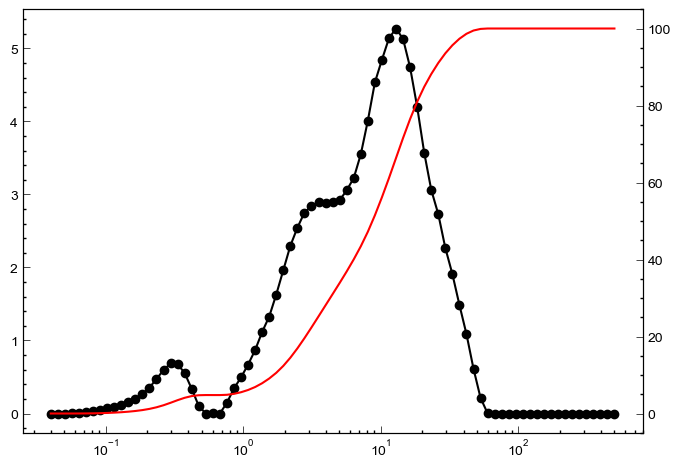

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
ax.plot(df_check["diameter[um]"], df_check["frequency"], "ko-")

ax2 = ax.twinx()
ax2.plot(df_check["diameter[um]"], df_check["cumulative_volume"], "r-")

plt.xscale('log')